In [1]:
from torch.utils.data import DataLoader
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoConfig, PreTrainedModel, AutoModel, AutoProcessor
import torch.nn as nn 
import torch
from tqdm.auto import tqdm
import torch.nn.functional as F
from datasets import load_dataset
from transformers.modeling_outputs import SequenceClassifierOutput
from collections import Counter
import numpy as np
import time
import random
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
from dataclasses import dataclass
from typing import List, Dict, Union, List, Any
import matplotlib.pyplot as plt

In [6]:
torch.set_float32_matmul_precision("high")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Uses device: {device}")

class EmotionClassifier(nn.Module):
    def __init__(self, hidden_size, num_labels=5, dropout=0.2):
        super().__init__()
        self.pool_norm = nn.LayerNorm(hidden_size)
        self.pre_dropout = nn.Dropout(dropout)

        mid1 = max(hidden_size // 2, num_labels * 4)
        mid2 = max(hidden_size // 4, num_labels * 2)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, mid1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(mid1),
            nn.Linear(mid1, mid2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(mid2),
            nn.Linear(mid2, num_labels),
        )

    def forward(self, hidden_states, attention_mask=None):
        if attention_mask is not None:
            lengths = attention_mask.sum(dim=1, keepdim=True)
            masked = hidden_states * attention_mask.unsqueeze(-1)
            pooled = masked.sum(dim=1) / lengths
        else:
            pooled = hidden_states.mean(dim=1)
        x = self.pool_norm(pooled)
        x = self.pre_dropout(x)
        logits = self.classifier(x)
        return logits

class ModelForEmotionClassification(PreTrainedModel):
    config_class = AutoConfig

    def __init__(
        self, config, model_name, num_labels=5, dropout=0.2
    ):
        super().__init__(config)
        self.encoder = AutoModel.from_pretrained(model_name, trust_remote_code=True).model.encoder
        hidden_size = config.encoder['d_model']
        self.classifier = EmotionClassifier(
            hidden_size, num_labels=num_labels, dropout=dropout
        )
        self.post_init()

    def forward(
        self,
        input_features: torch.Tensor,
        input_lengths: torch.Tensor,
        attention_mask: torch.Tensor = None,
        labels: torch.Tensor = None
    ) -> SequenceClassifierOutput:
        encoded, out_lens = self.encoder(input_features, input_lengths)
        hidden_states = encoded.transpose(1, 2)

        if attention_mask is None:
            max_t = hidden_states.size(1)
            attention_mask = (
                torch.arange(max_t, device=out_lens.device)
                .unsqueeze(0)
                .lt(out_lens.unsqueeze(1))
                .long()
            )

        logits = self.classifier(hidden_states, attention_mask=attention_mask)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)
        
model_name = "nixiieee/gigaam-rnnt-emotion-classifier-dusha"
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
model = ModelForEmotionClassification.from_pretrained(model_name, config=config, model_name=model_name, num_labels=5, dropout=0.05).to(device)

Uses device: cuda:1


Some weights of GigaAMRNNTHF were not initialized from the model checkpoint at nixiieee/gigaam-rnnt-emotion-classifier-dusha and are newly initialized: ['model.encoder.layers.0.conv.batch_norm.bias', 'model.encoder.layers.0.conv.batch_norm.num_batches_tracked', 'model.encoder.layers.0.conv.batch_norm.running_mean', 'model.encoder.layers.0.conv.batch_norm.running_var', 'model.encoder.layers.0.conv.batch_norm.weight', 'model.encoder.layers.0.conv.depthwise_conv.bias', 'model.encoder.layers.0.conv.depthwise_conv.weight', 'model.encoder.layers.0.conv.pointwise_conv1.bias', 'model.encoder.layers.0.conv.pointwise_conv1.weight', 'model.encoder.layers.0.conv.pointwise_conv2.bias', 'model.encoder.layers.0.conv.pointwise_conv2.weight', 'model.encoder.layers.0.feed_forward1.linear1.bias', 'model.encoder.layers.0.feed_forward1.linear1.weight', 'model.encoder.layers.0.feed_forward1.linear2.bias', 'model.encoder.layers.0.feed_forward1.linear2.weight', 'model.encoder.layers.0.feed_forward2.linear1.bi

In [8]:
ds = load_dataset("nixiieee/dusha_balanced", split='test')

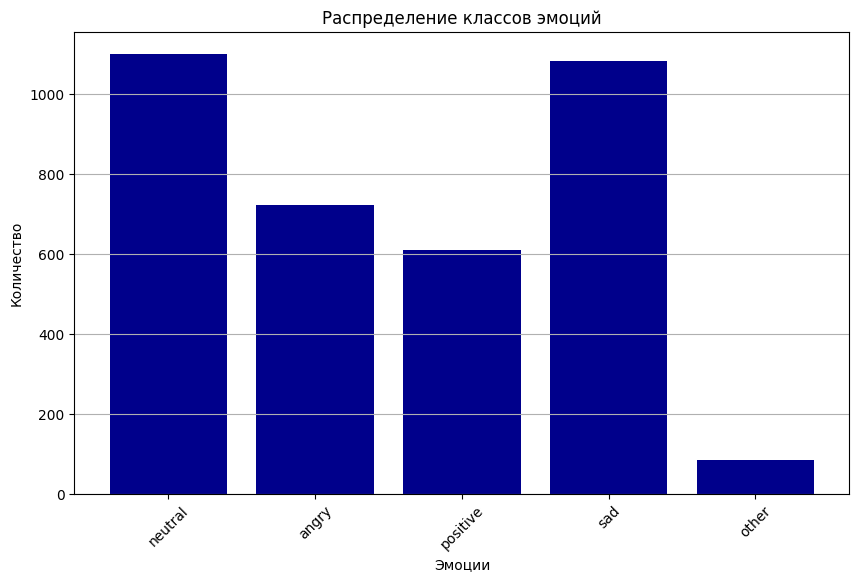

In [9]:
class_counts = Counter(ds['emotion'])

label_mapping = {0: "neutral", 1: "angry", 2: "positive", 3: "sad", 4: "other"}
labels = list(label_mapping.values())
values = [class_counts[key] for key in label_mapping.keys()]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='darkblue')
plt.title('Распределение классов эмоций')
plt.xlabel('Эмоции')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [10]:
@dataclass
class DataCollatorForEncoderClassification:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        tensors = [
            f["input_features"]
            if isinstance(f["input_features"], torch.Tensor)
            else torch.tensor(f["input_features"], dtype=torch.float32)
            for f in features
        ]
        seq_lens = [t.shape[0] for t in tensors]
        assert len(set(seq_lens)) == 1, "Все sequences в батче должны быть одинаковой длины"
        batch_inputs = torch.stack(tensors, dim=0)  # shape: [B, T, feat_in]

        batch_labels = torch.tensor(
            [f["labels"] for f in features], dtype=torch.long
        )
        batch_lens = torch.tensor(
            [f["input_lengths"] for f in features], dtype=torch.long
        )

        return {
            "input_features": batch_inputs,
            "input_lengths": batch_lens,
            "labels": batch_labels,
        }


def prepare_dataset(batch):
    audio = batch["audio"]
    processed = processor(
        audio["array"], sampling_rate=audio["sampling_rate"]
    )   
    batch["input_features"] = processed["input_features"][0]
    batch["input_lengths"] = processed["input_lengths"][0]
    batch["labels"] = batch["emotion"]
    return batch


test_ds = ds.map(
    prepare_dataset, remove_columns=["audio", "emotion"],
    num_proc=1
)

data_collator = DataCollatorForEncoderClassification(processor)

In [11]:
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=data_collator
)

In [12]:
all_true_labels = np.array(ds['emotion'])

In [13]:
all_true_labels

array([0, 3, 3, ..., 2, 3, 1])

In [ ]:
def mc_dropout_predictions(model, data_loader, T=10):
    model.train()
    all_preds = []
    iteration_times = []

    with torch.no_grad():
        for t in tqdm(range(T), desc='MC Dropout итерации'):
            start_time = time.time()
            preds = []
            for x_batch in tqdm(data_loader, desc="Processing all batches"):
                batch = {k: v.to(device) for k, v in x_batch.items()}
                labels = batch['labels'].cpu().numpy()
                outputs = model(input_features=batch['input_features'], input_lengths=batch['input_lengths'])
                logits = outputs.logits
                y_pred = F.softmax(logits, dim=1)
                preds.append(y_pred.cpu().numpy())
            preds = np.vstack(preds)
            all_preds.append(preds)
            iteration_times.append(time.time() - start_time)
            print(f'Итерация {t+1}/{T} завершена за {iteration_times[-1]:.4f} секунд.')

    # all_preds = np.concatenate(all_preds, axis=0)
    all_preds = np.array(all_preds)
    mean_preds = all_preds.mean(axis=0)
    print(f'Среднее время итерации: {np.mean(iteration_times):.4f} секунд.')
    return mean_preds, all_preds

In [15]:
def get_predictions(model, data_loader):
    all_preds = []
    with torch.no_grad():
        for x_batch in tqdm(data_loader, desc="Processing all batches"):
            batch = {k: v.to(device) for k, v in x_batch.items()}
            labels = batch['labels'].cpu().numpy()
            outputs = model(input_features=batch['input_features'], input_lengths=batch['input_lengths'])
            logits = outputs.logits
            y_pred = F.softmax(logits, dim=1)
            label_pred = torch.argmax(y_pred, dim=-1)
            all_preds.append(label_pred.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    return all_preds

In [16]:
def get_probs(model, data_loader):
    all_probs = []
    with torch.no_grad():
        for x_batch in tqdm(data_loader, desc="Processing all batches"):
            batch = {k: v.to(device) for k, v in x_batch.items()}
            labels = batch['labels'].cpu().numpy()
            outputs = model(input_features=batch['input_features'], input_lengths=batch['input_lengths'])
            logits = outputs.logits
            probs = F.softmax(logits, dim=-1).cpu().numpy()
            all_probs.append(probs)
        all_probs = np.vstack(all_probs)

    return all_probs

In [18]:
model.eval()
test_preds = get_predictions(model, test_loader)

Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

In [19]:
model.eval()
pred__test_probs = get_probs(model, test_loader)

Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

In [20]:
pred__test_probs.shape

(3601, 5)

Метрики без mc dropout

In [21]:
accuracy = accuracy_score(all_true_labels, test_preds)
balanced_accuracy = balanced_accuracy_score(all_true_labels, test_preds)
precision = precision_score(all_true_labels, test_preds, average='macro')
recall = recall_score(all_true_labels, test_preds, average='macro')
f1 = f1_score(all_true_labels, test_preds, average='macro')

print(f"acc: {accuracy:.4f}")
print(f"Balanced acc: {balanced_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

acc: 0.8153
Balanced acc: 0.8368
Precision: 0.8444
Recall: 0.8368
F1 Score: 0.8403


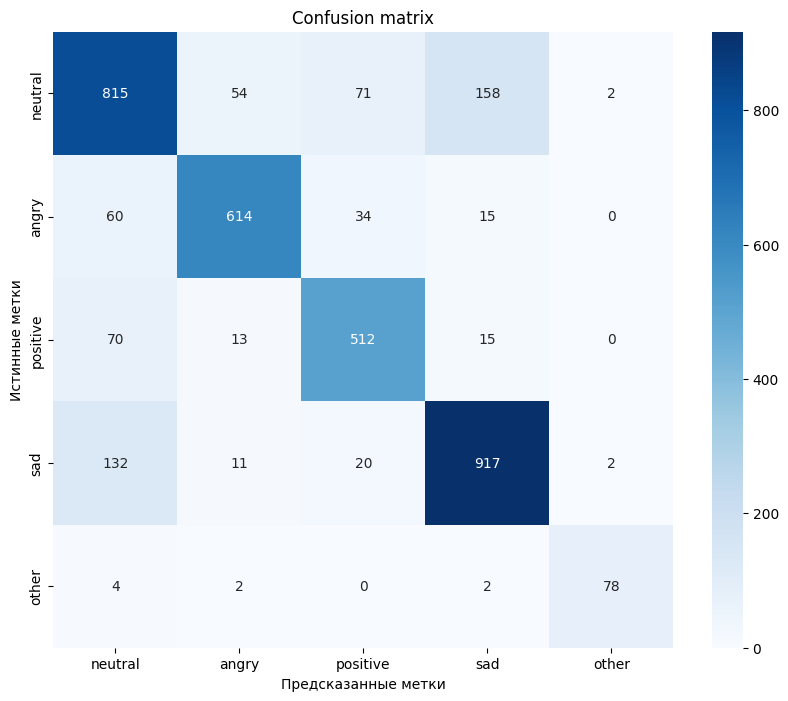

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_true_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.title('Confusion matrix')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.show()

In [ ]:
def evaluate_mean_preds(all_labels, all_preds):
    mean_probs = np.mean(all_preds, axis=0)
    class_preds = np.argmax(mean_probs, axis=1)
    accuracy = accuracy_score(all_labels, class_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, class_preds)
    precision = precision_score(all_labels, class_preds, average='weighted')
    recall = recall_score(all_labels, class_preds, average='weighted')
    f1 = f1_score(all_labels, class_preds, average='weighted')
    
    print(f"acc: {accuracy:.4f}")
    print(f"Balanced acc: {balanced_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def evaluate_confusion_matrix(all_labels, all_preds):
    mean_probs = np.mean(all_preds, axis=0)
    class_preds = np.argmax(mean_probs, axis=1)
    
    cm = confusion_matrix(all_labels, class_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return cm

In [25]:
def visualize_uncertainties(all_mc_preds, all_labels):
    class_preds = all_mc_preds.argmax(axis=2)
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis = 0, arr = class_preds)
    correct_with_mc = (final_predictions == all_labels).sum()
    accuracy_with_mc = correct_with_mc / len(all_labels) * 100

    print(f"Точность с MC Dropout: {accuracy_with_mc:.2f}%")
    
    uncertainties = np.var(class_preds, axis = 0)
    
    plt.figure(figsize = (10, 6))
    plt.hist(uncertainties, bins = 50, alpha = 0.75)
    plt.title("Распределение неопределенности предсказаний")
    plt.xlabel("Неопределенность (Дисперсия)")
    plt.ylabel("Частота")
    plt.xticks(np.arange(min(uncertainties), max(uncertainties), 1))
    plt.grid(True)
    plt.show()

In [26]:
model.train()
mean_preds, all_preds = mc_dropout_predictions(model, test_loader)

MC Dropout итерации:   0%|          | 0/10 [00:00<?, ?it/s]

Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 1/10 завершена за 1576.4789 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 2/10 завершена за 1561.5481 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 3/10 завершена за 1494.6718 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 4/10 завершена за 1507.2821 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 5/10 завершена за 1690.6437 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 6/10 завершена за 1714.8647 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 7/10 завершена за 1699.7073 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 8/10 завершена за 1703.3586 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 9/10 завершена за 1700.8387 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 10/10 завершена за 1693.5269 секунд.
Среднее время итерации: 1634.2921 секунд.


In [46]:
evaluate_mean_preds(all_true_labels, all_preds)

acc: 0.8162
Balanced acc: 0.8346
Precision: 0.8172
Recall: 0.8162
F1 Score: 0.8166


In [ ]:
all_preds.shape

(10, 3601, 5)

Точность с MC Dropout: 81.59%


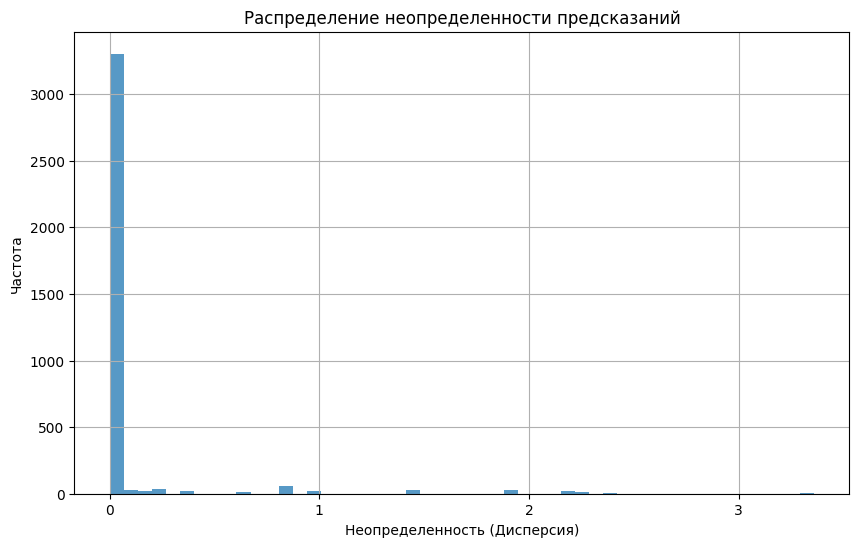

In [40]:
visualize_uncertainties(all_preds, all_true_labels)

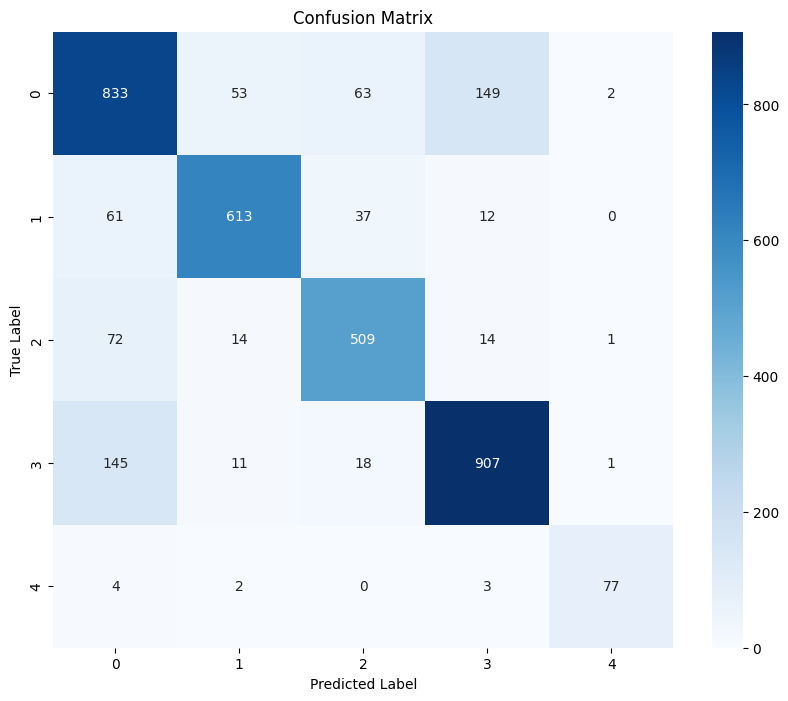

array([[833,  53,  63, 149,   2],
       [ 61, 613,  37,  12,   0],
       [ 72,  14, 509,  14,   1],
       [145,  11,  18, 907,   1],
       [  4,   2,   0,   3,  77]])

In [41]:
evaluate_confusion_matrix(all_true_labels, all_preds)

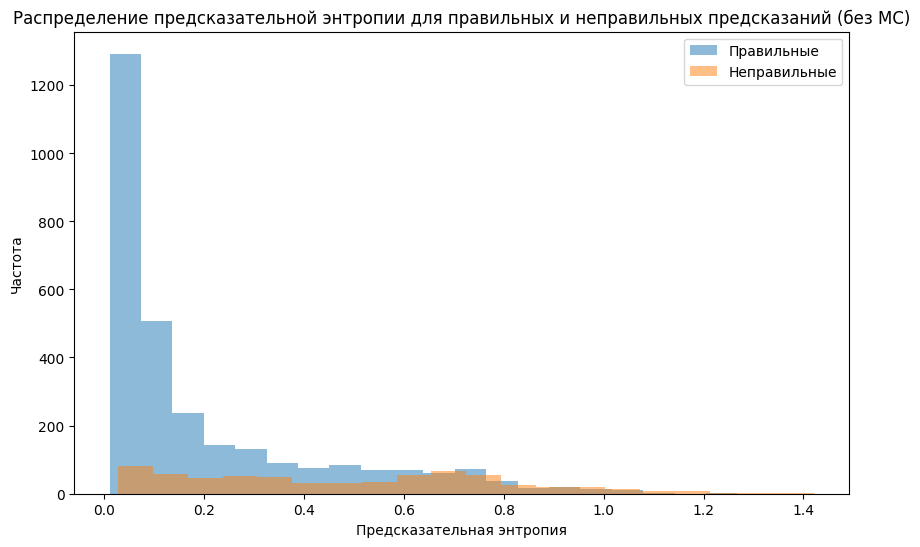

Класс 0: Средняя энтропия = 0.3092
Класс 1: Средняя энтропия = 0.2267
Класс 2: Средняя энтропия = 0.2157
Класс 3: Средняя энтропия = 0.2373
Класс 4: Средняя энтропия = 0.2158


In [42]:
def compute_predictive_entropy(all_preds):
    entropy = -np.sum(all_preds * np.log(all_preds + 1e-10), axis=1)
    return entropy

entropies = compute_predictive_entropy(pred__test_probs)
predicted_labels = np.argmax(pred__test_probs, axis=1)
correct = (predicted_labels == all_true_labels)

plt.figure(figsize=(10, 6))
plt.hist(entropies[correct], bins=20, alpha=0.5, label='Правильные')
plt.hist(entropies[~correct], bins=20, alpha=0.5, label='Неправильные')
plt.xlabel('Предсказательная энтропия')
plt.ylabel('Частота')
plt.title('Распределение предсказательной энтропии для правильных и неправильных предсказаний (без МС)')
plt.legend()
plt.show()

for class_idx in np.unique(all_true_labels):
    class_entropies = entropies[all_true_labels == class_idx]
    print(f'Класс {class_idx}: Средняя энтропия = {np.mean(class_entropies):.4f}')

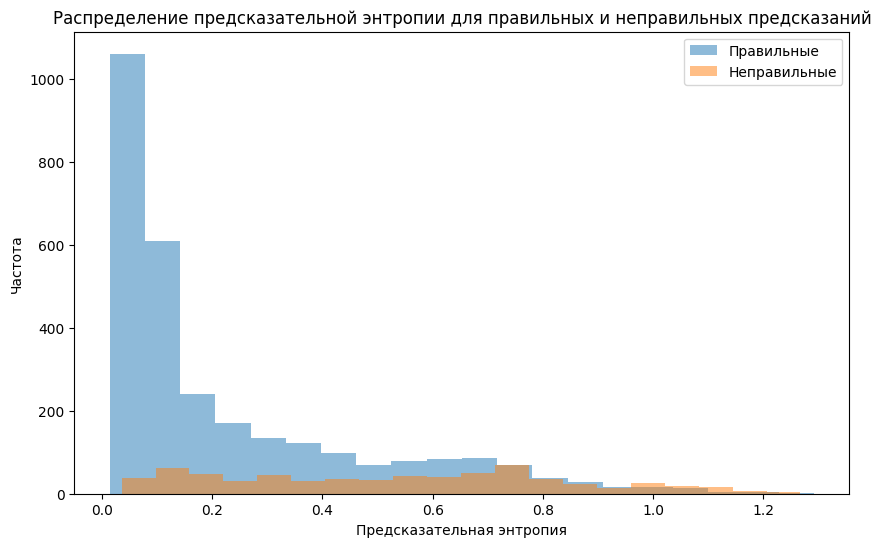

Класс 0: Средняя энтропия = 0.3378
Класс 1: Средняя энтропия = 0.2496
Класс 2: Средняя энтропия = 0.2487
Класс 3: Средняя энтропия = 0.2770
Класс 4: Средняя энтропия = 0.2798


In [43]:
# для вероятностей без МС Dropout
def compute_predictive_entropy(all_preds):
    mean_probs = np.mean(all_preds, axis=0)
    entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-10), axis=1)
    return entropy

entropies = compute_predictive_entropy(all_preds)
predicted_labels = np.argmax(mean_preds, axis=1)
correct = (predicted_labels == all_true_labels)

plt.figure(figsize=(10, 6))
plt.hist(entropies[correct], bins=20, alpha=0.5, label='Правильные')
plt.hist(entropies[~correct], bins=20, alpha=0.5, label='Неправильные')
plt.xlabel('Предсказательная энтропия')
plt.ylabel('Частота')
plt.title('Распределение предсказательной энтропии для правильных и неправильных предсказаний')
plt.legend()
plt.show()

for class_idx in np.unique(all_true_labels):
    class_entropies = entropies[all_true_labels == class_idx]
    print(f'Класс {class_idx}: Средняя энтропия = {np.mean(class_entropies):.4f}')

In [44]:
# Рассмотрим средние значения вероятностей каждого класса
def analyze_aposterior_mean(mean_preds):
    sample_idx = random.randint(0, mean_preds.shape[0])
    print(f"Истинный класс: {all_true_labels[sample_idx]}")
    classes = [f'Класс {i}' for i in range(mean_preds.shape[1])]
    plt.figure(figsize=(10, 6))
    probs = mean_preds[sample_idx]
    bars = plt.bar(classes, probs, color='skyblue')
    plt.xlabel('Классы')
    plt.ylabel('Вероятность')
    plt.title('Вероятности классов для одного семпла')
    plt.ylim(0, 1)
    
    # подписи вероятностей над столбиками
    for bar, prob in zip(bars, probs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{prob:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Истинный класс: 3


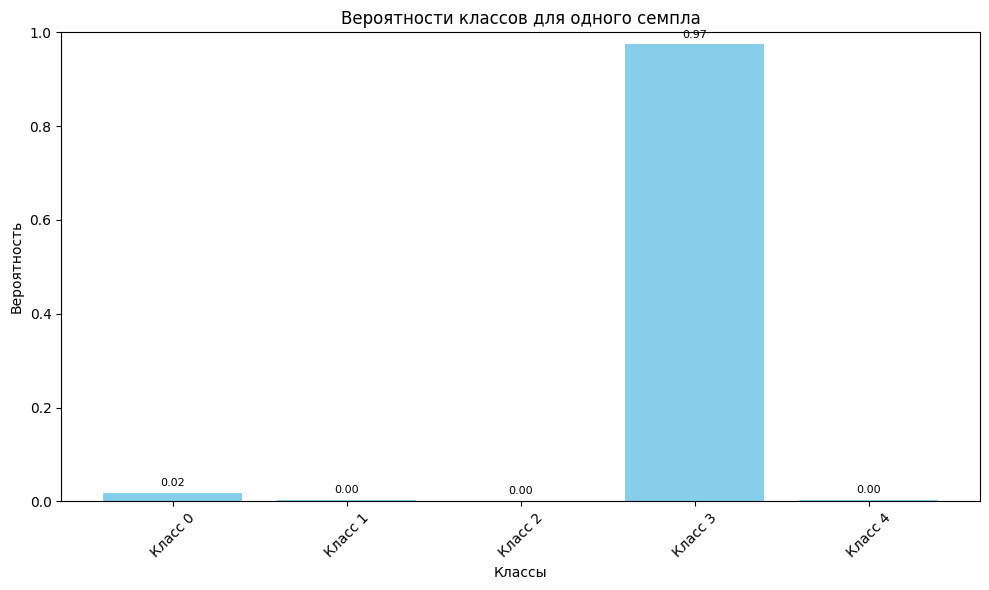

Истинный класс: 3


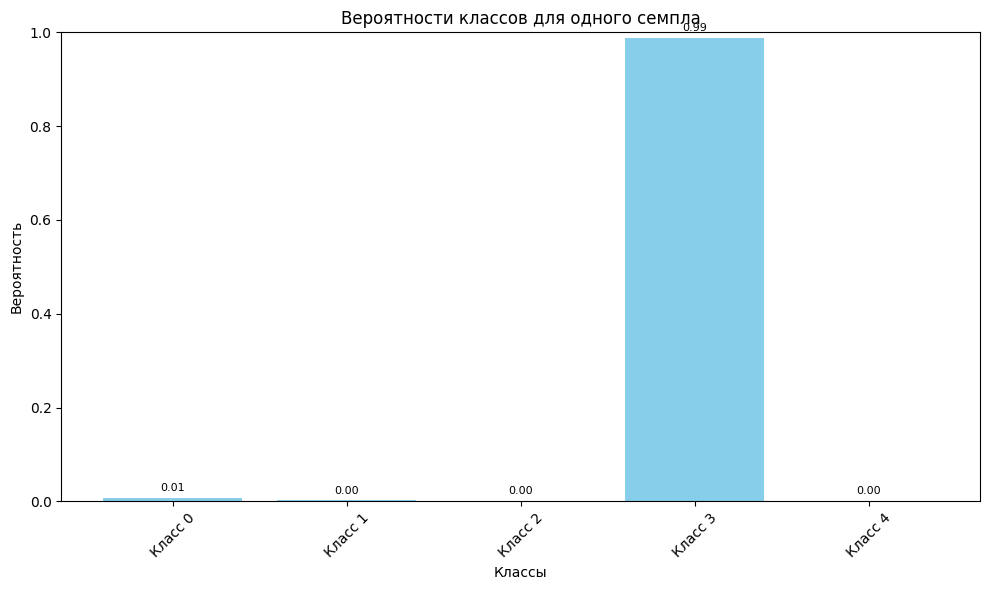

Истинный класс: 1


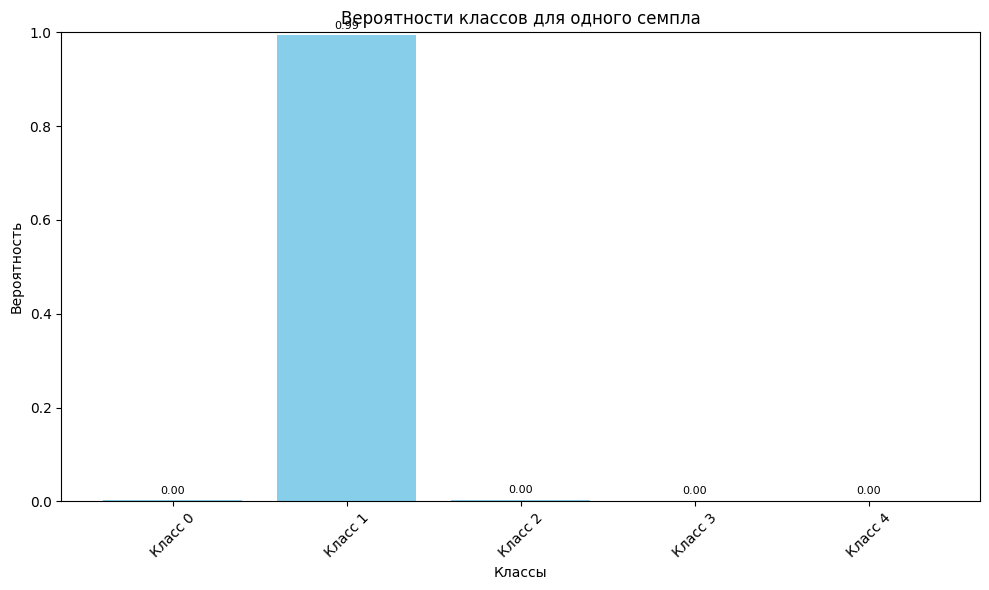

Истинный класс: 0


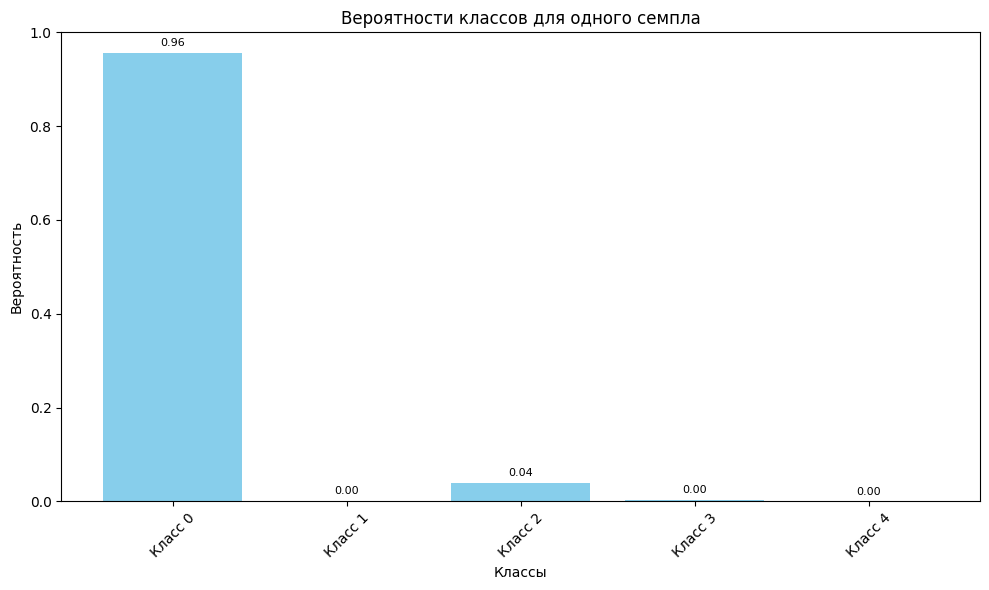

Истинный класс: 3


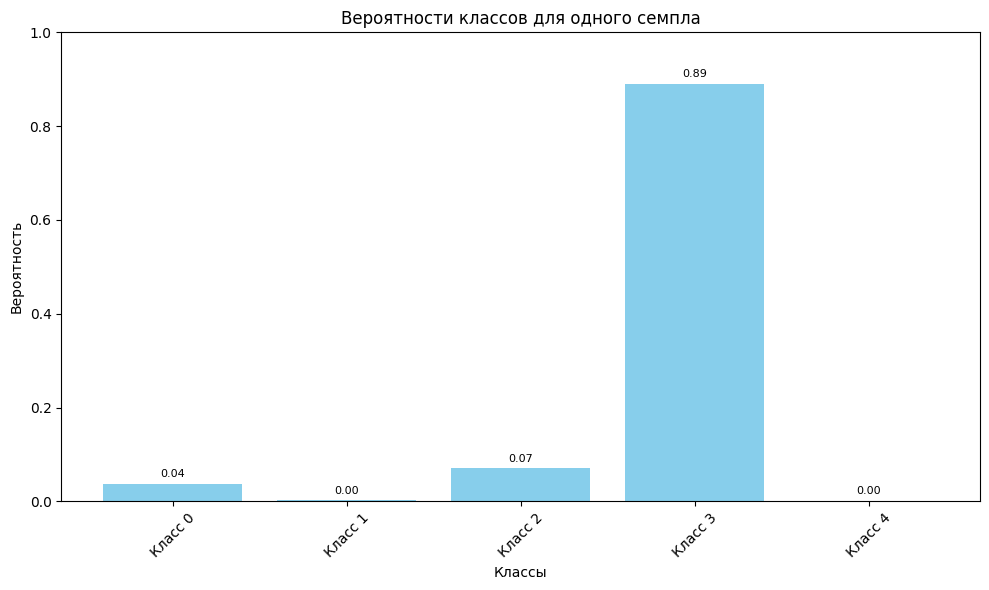

Истинный класс: 3


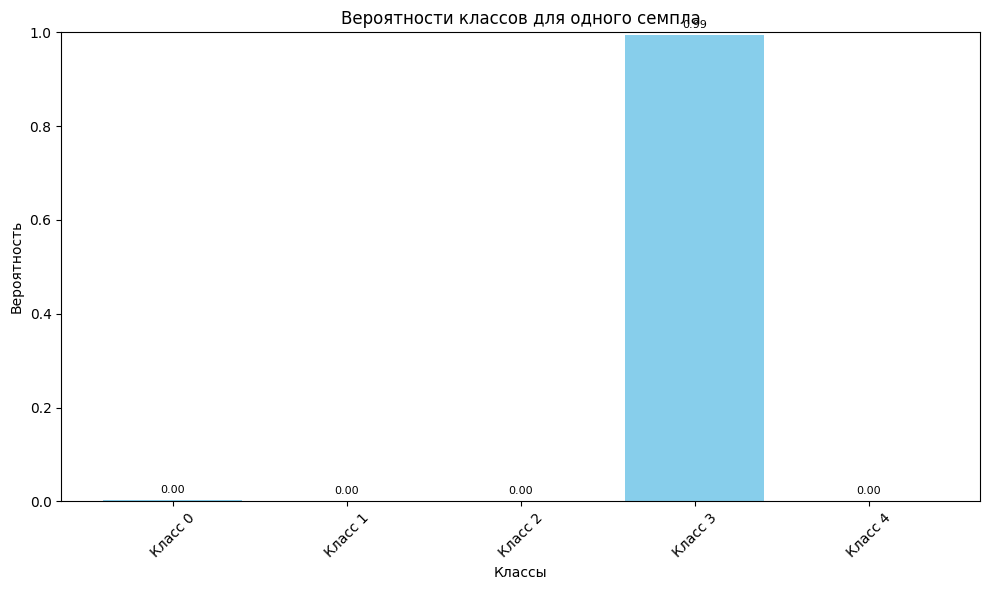

Истинный класс: 1


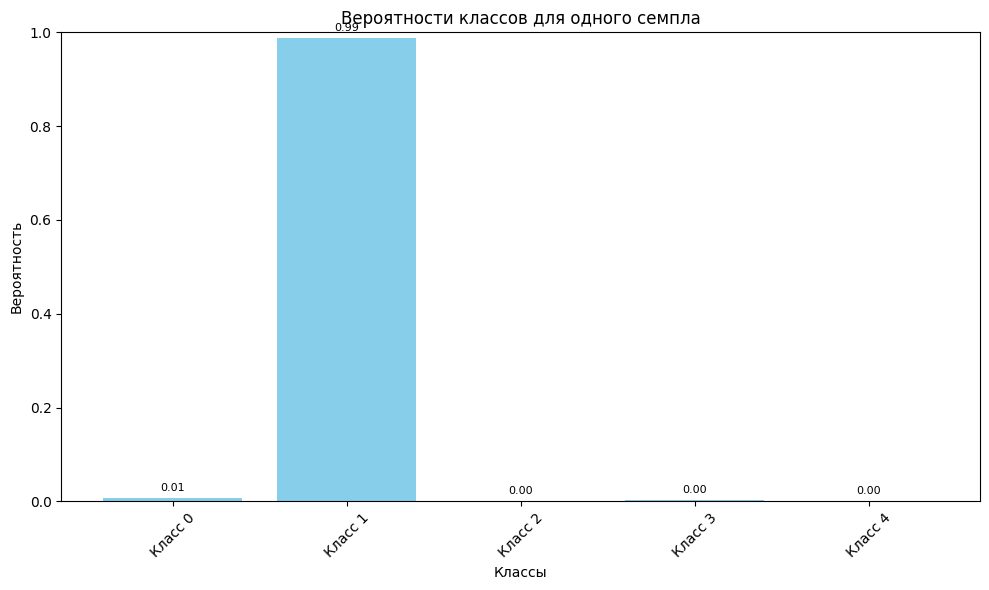

Истинный класс: 3


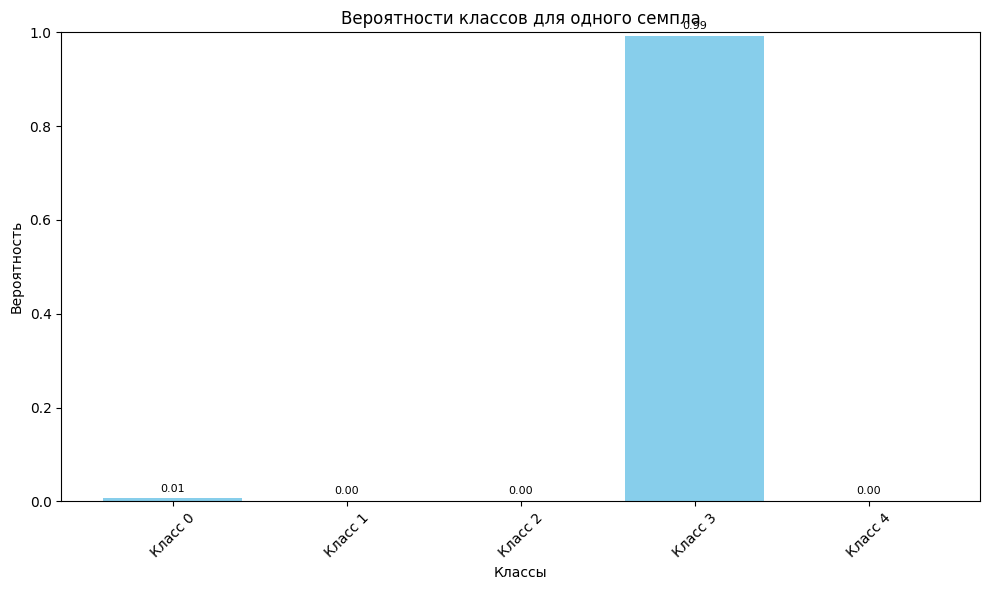

Истинный класс: 0


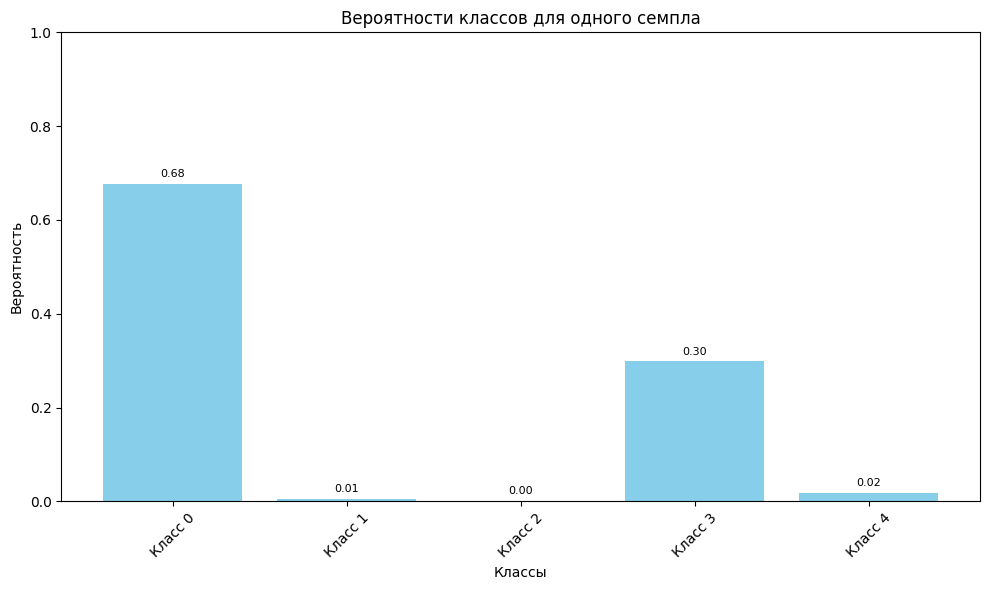

Истинный класс: 0


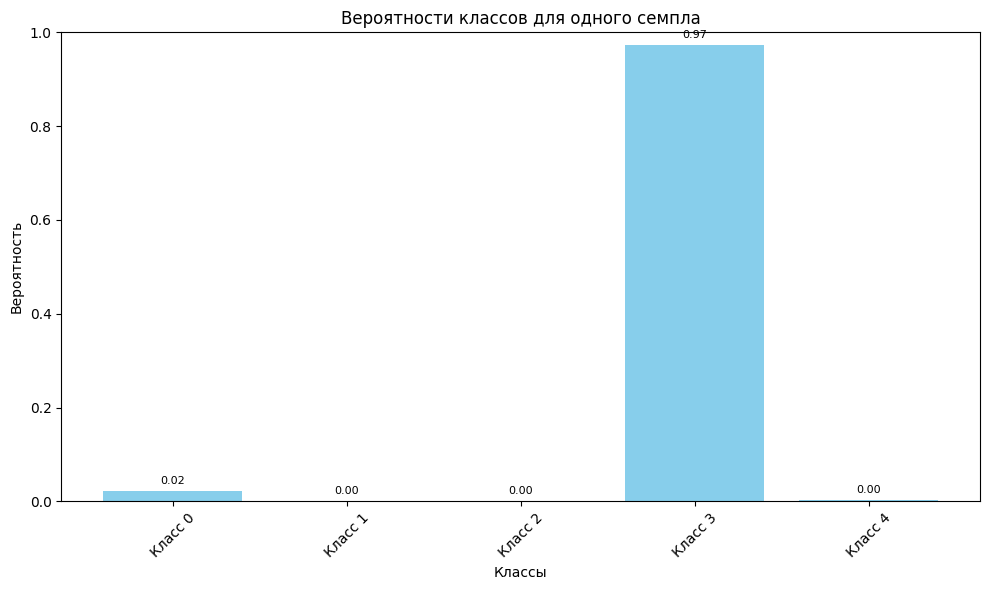

Истинный класс: 0


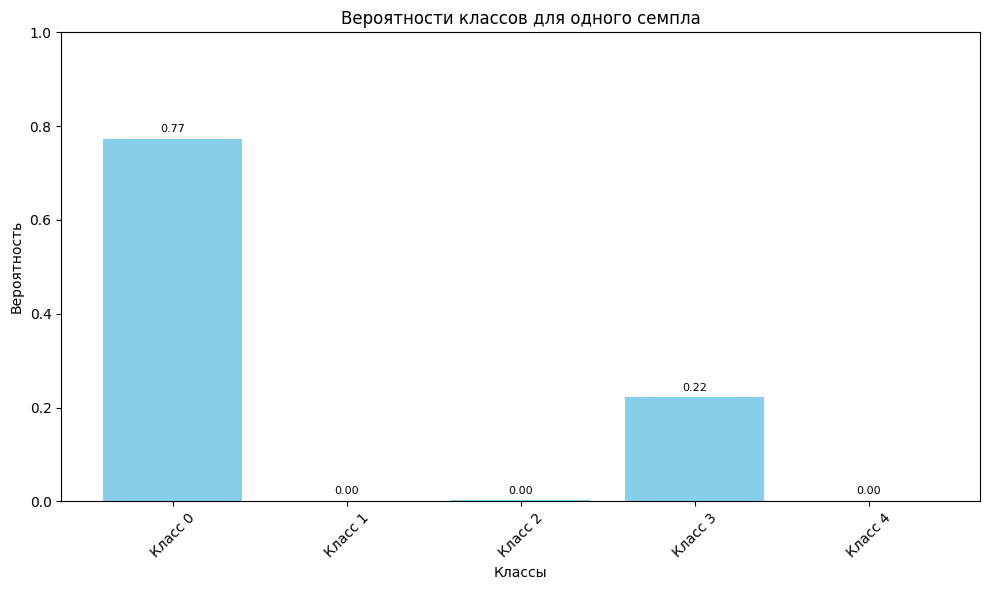

Истинный класс: 0


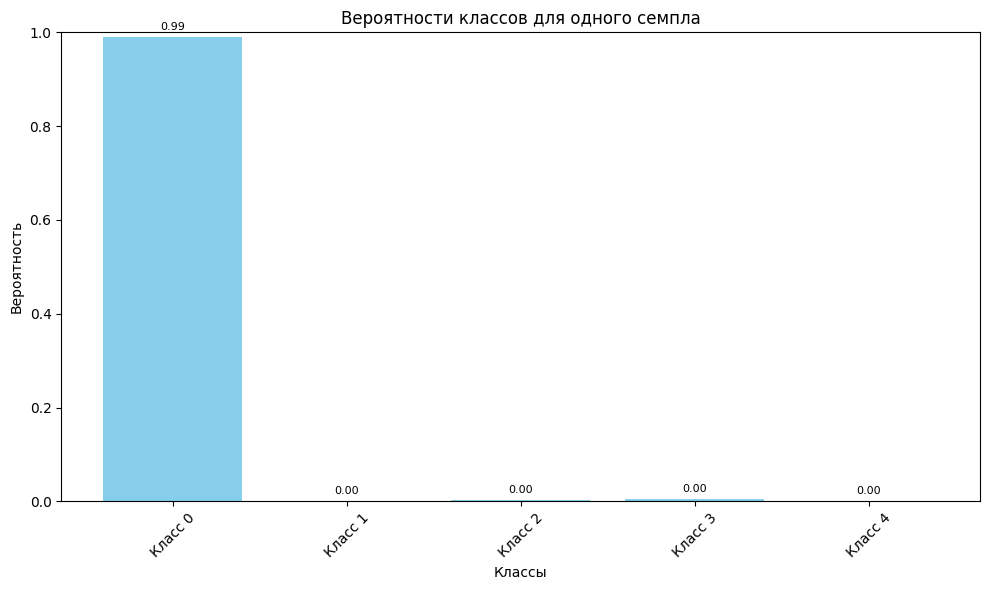

Истинный класс: 3


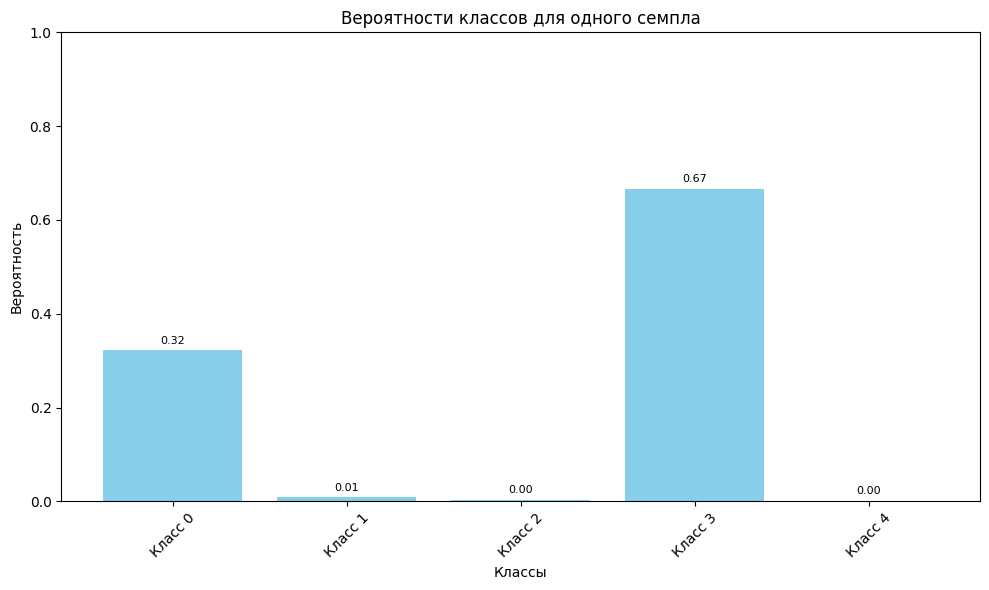

Истинный класс: 3


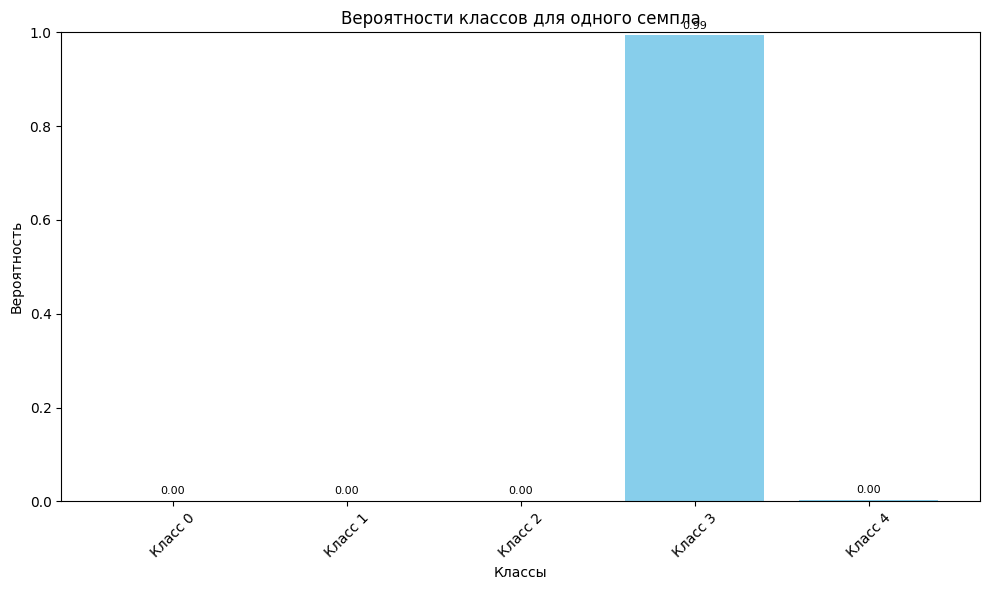

Истинный класс: 2


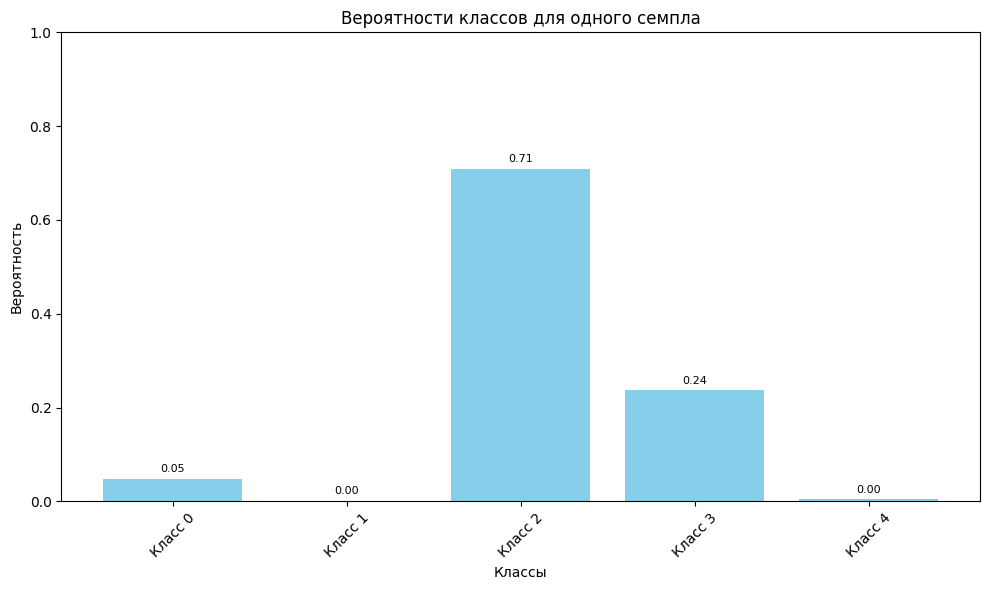

Истинный класс: 0


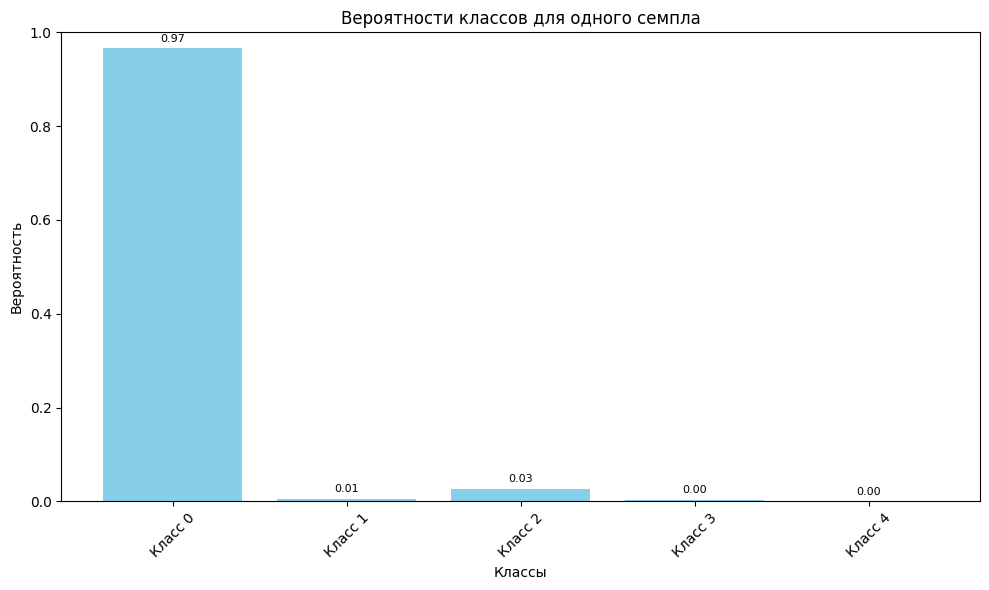

Истинный класс: 3


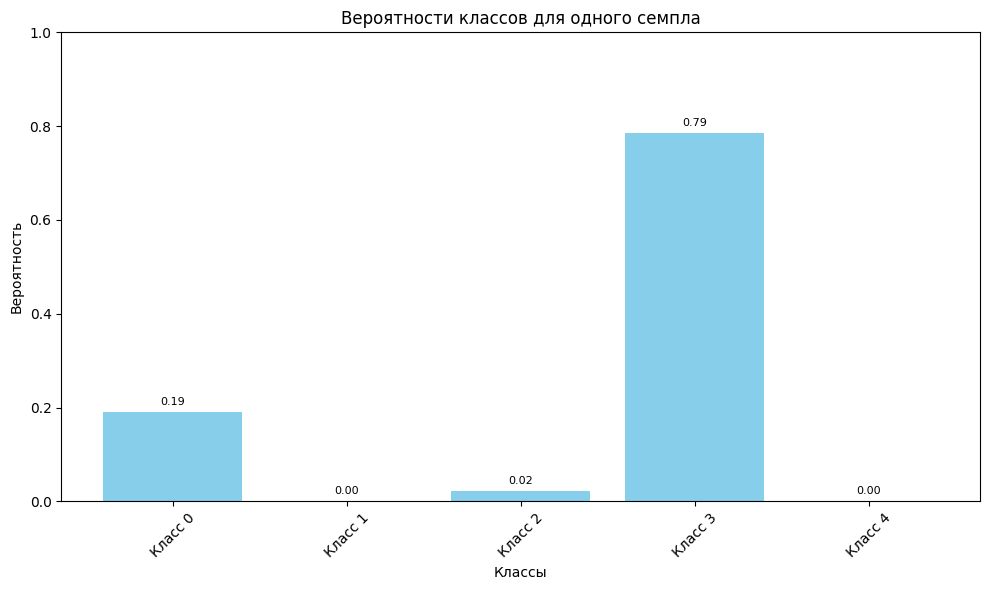

Истинный класс: 1


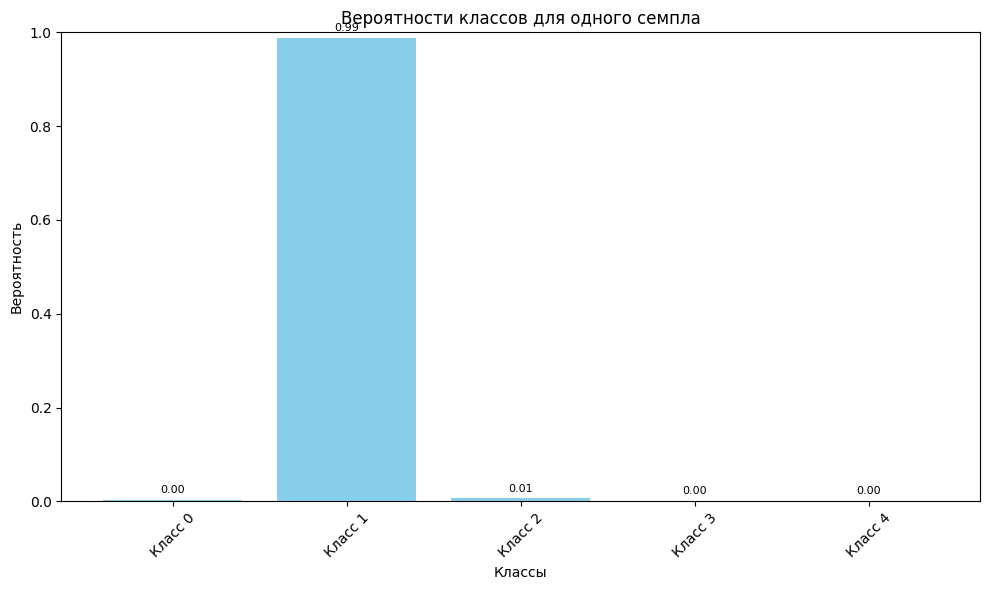

Истинный класс: 2


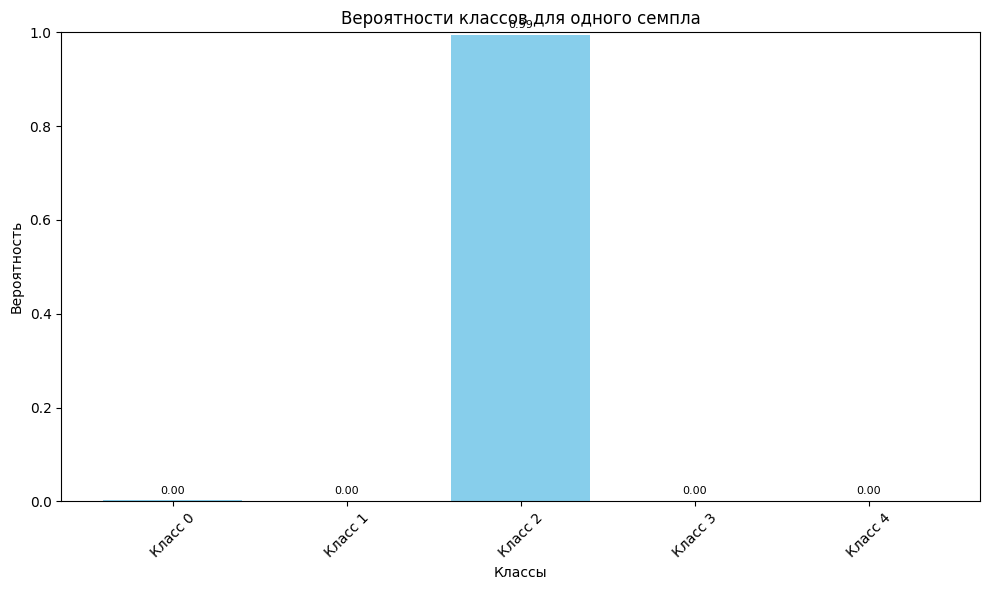

Истинный класс: 1


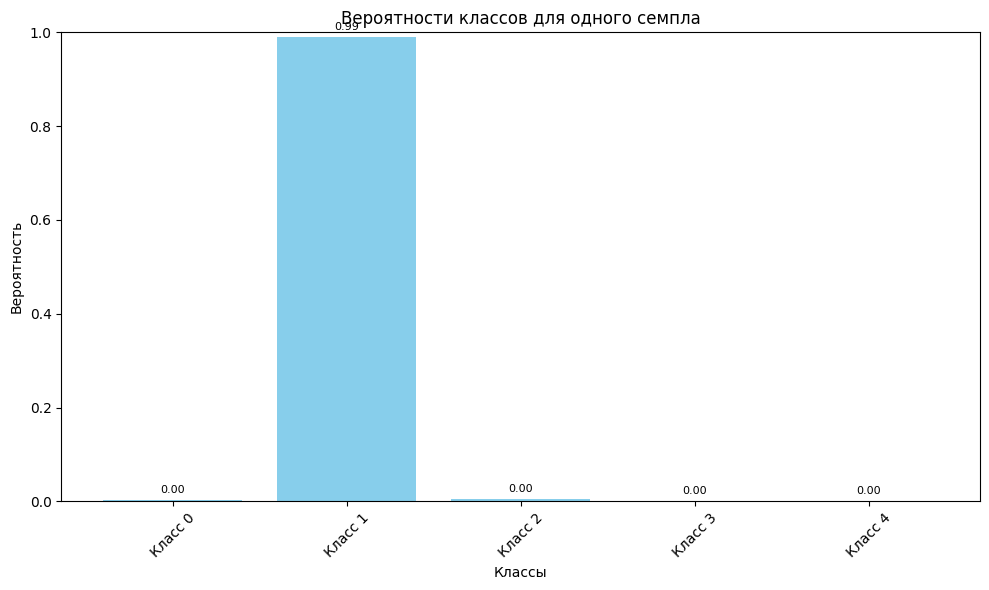

In [45]:
for _ in range(20):
    analyze_aposterior_mean(mean_preds)

In [47]:
# Рассмотрим распределения T вероятностей для одного сэмпла
def analyze_aposterior(all_mc_preds):
    sample_idx = random.randint(0, all_mc_preds.shape[1])
    print(f"Истинный класс: {all_true_labels[sample_idx]}")
    for class_idx in range(len(np.unique(all_true_labels))): 
        probs_for_class = all_mc_preds[:, sample_idx, class_idx]  # т.е. T значений вероятности для каждого класса
        
        plt.hist(probs_for_class, bins=10, alpha=0.7)
        plt.title(f'Гистограмма вероятностей для сэмпла {sample_idx}, класса {class_idx}')
        plt.xlabel('Вероятность')
        plt.ylabel('Частота')
        plt.show()

Истинный класс: 1


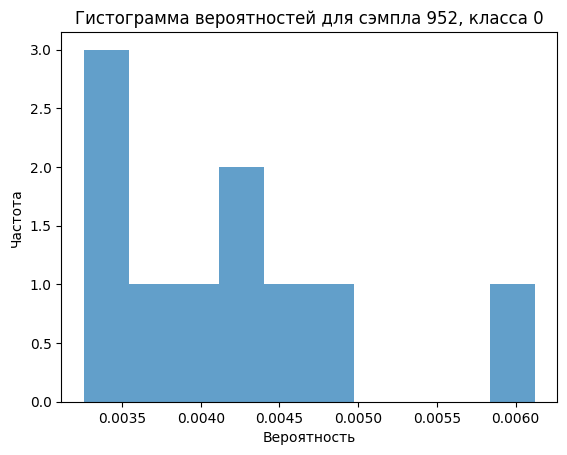

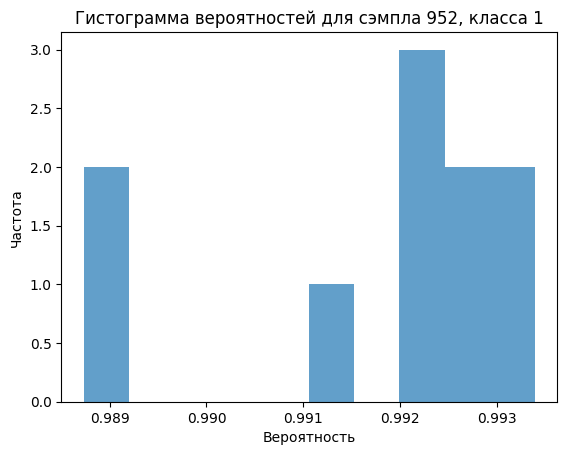

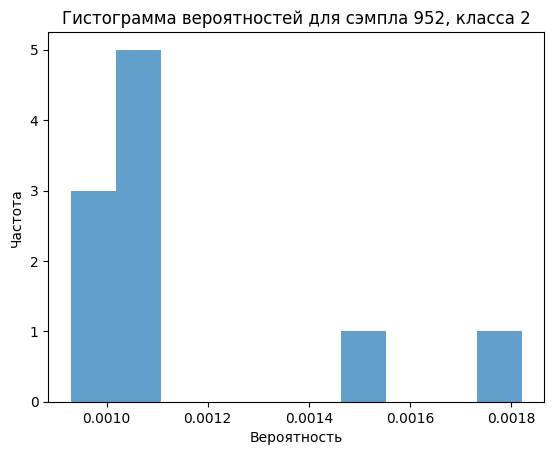

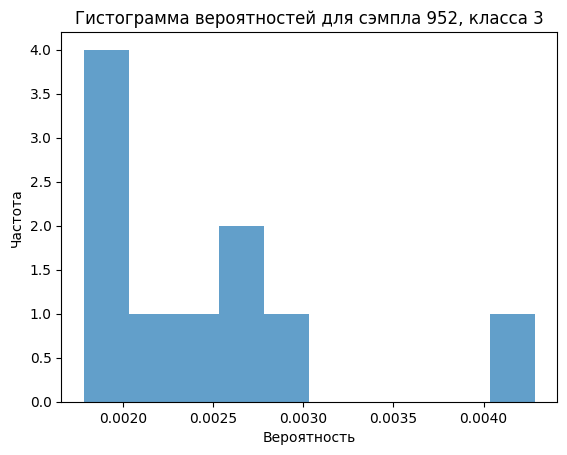

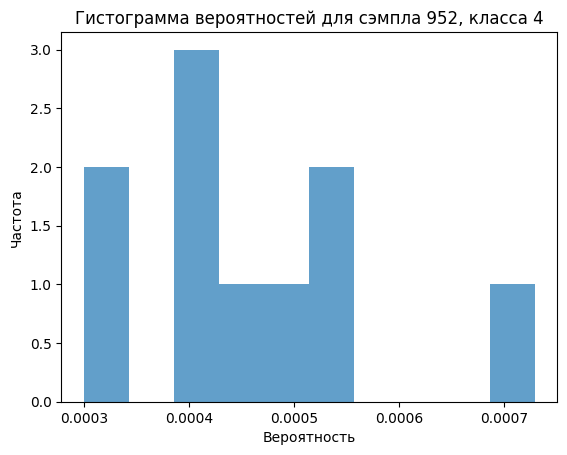

In [48]:
analyze_aposterior(all_preds)

In [30]:
np.save('all_preds_mc_10_iterations.npy', all_preds)

In [ ]:
# mc_preds = np.load('all_preds_mc_10_iterations.npy')
# mc_preds.shape
mc_preds = all_preds

In [9]:
# анализ для МС и для обычных вероятностей
label_mapping = {0: "neutral", 1: "angry", 2: "positive", 3: "sad", 4: "other"}
def analyze_aposterior_mean(mc_preds, eval_preds):
    mean_preds = np.mean(mc_preds, axis=0)
    sample_idx = random.randint(0, mean_preds.shape[0] - 1)
    class_idx = all_true_labels[sample_idx]
    class_name = label_mapping[class_idx]
    print(f"Истинный класс: {class_name}, id = {sample_idx}")
    n_classes = mean_preds.shape[1]
    classes = [f'{label_mapping[i]}' for i in range(n_classes)]
    plt.figure(figsize=(8, 6))
    x = np.arange(n_classes)
    width = 0.35
    mean_probs = mean_preds[sample_idx]
    eval_probs = eval_preds[sample_idx]
    bars1 = plt.bar(x - width/2, mean_probs, width, color='skyblue', label='MC Dropout Mean')
    bars2 = plt.bar(x + width/2, eval_probs, width, color='blue', label='Model Eval')
    for bars, probs in [(bars1, mean_probs), (bars2, eval_probs)]:
        for bar, prob in zip(bars, probs):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{prob:.2f}', ha='center', va='bottom', fontsize=8)
    plt.xlabel('Классы')
    plt.ylabel('Вероятность')
    plt.title('Вероятности классов для одного семпла')
    plt.ylim(0, 1)
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
for _ in range(5):
    analyze_aposterior_mean(mc_preds, pred__test_probs)